In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys
sys.executable

'/usr/bin/python3'

# Utils
### - Implement

In [2]:
def get_available_actions(state, grid_reward):
    """
    현재 상태에서 가능한 행동 반환.

    Args:
        state (tuple): 현재 상태 (x, y).
        grid_reward (np.ndarray): 그리드 보상 배열.

    Returns:
        list: 가능한 행동 리스트.
    """
    actions = []
    x, y = state
    grid_size = grid_reward.shape[0]

    # 각 방향에 대해 경계를 벗어나지 않는 경우 행동 추가
    if x > 0:  # 위로 이동 가능
        actions.append(ACTION_UP)
    if x < grid_size - 1:  # 아래로 이동 가능
        actions.append(ACTION_DOWN)
    if y > 0:  # 왼쪽으로 이동 가능
        actions.append(ACTION_LEFT)
    if y < grid_size - 1:  # 오른쪽으로 이동 가능
        actions.append(ACTION_RIGHT)

    return actions

def get_transition(state, action, grid_reward):
    """
    현재 상태와 행동에 따라 다음 상태와 보상 반환.

    Args:
        state (tuple): 현재 상태 (x, y).
        action (int): 수행할 행동 (ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT).
        grid_reward (np.ndarray): 그리드 보상 배열.

    Returns:
        tuple: 다음 상태와 보상 (next_state, reward).
    """
    x, y = state
    grid_size = grid_reward.shape[0]

    # 다음 상태 계산
    if action == ACTION_UP:
        next_state = (max(x - 1, 0), y)
    elif action == ACTION_DOWN:
        next_state = (min(x + 1, grid_size - 1), y)
    elif action == ACTION_LEFT:
        next_state = (x, max(y - 1, 0))
    elif action == ACTION_RIGHT:
        next_state = (x, min(y + 1, grid_size - 1))
    else:
        next_state = state

    # 다음 상태의 보상
    reward = grid_reward[state]
    return next_state, reward


# Utils
### - Given

In [3]:
def generate_grid_world(obstacles):
    grid_size = 7
    grid_reward = np.full((grid_size, grid_size), -1)

    for (x, y) in obstacles:
        grid_reward[x, y] = -100

    # Define start and end positions
    start = (0, 0)
    end = (6, 6)
    grid_reward[end[0], end[1]] = 0

    return grid_reward, start, end

def print_policy(policy):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ')
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            else:
                policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
    for row in policy_symbols:
        print(' '.join(row))

def visualize_map(data, title):
    plt.imshow(data, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Value')
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="Green")
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

def visualize_policy(policy, start, end, title, israndom):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ', dtype="U10")
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            elif (x, y) == (start[0], start[1]):
                policy_symbols[x, y] = 'S'  # Start
            else:
                if israndom:
                    policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
                else:
                    temp_policy_symbol = 0
                    actions = [int(value) for value in str(policy[x, y])]
                    for i, value in enumerate(actions):
                        if i == 0:
                            temp_policy_symbol = ACTION_SYMBOLS.get(value, ' ')
                        else:
                            temp_policy_symbol += ACTION_SYMBOLS.get(value, ' ')
                    policy_symbols[x, y] = temp_policy_symbol

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(np.arange(0, grid_size+1, 1))
    ax.set_yticks(np.arange(0, grid_size+1, 1))
    ax.set_yticklabels(np.arange(grid_size, -1, -1))
    ax.grid(True)

    for x in range(grid_size):
        for y in range(grid_size):
            if israndom:
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=20)
            else:
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=10)
            if grid[x, y] == -100:
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='black')
                ax.add_patch(rect)
            elif (x, y) == (end[0], end[1]):
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='green', alpha=0.3)
                ax.add_patch(rect)
            elif (x, y) == (start[0], start[1]):
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='blue', alpha=0.3)
                ax.add_patch(rect)

    plt.title(title)
    plt.show()

# Policy initialization
### - Implement

In [4]:
def policy_generator(grid_reward, israndom, isall=False):
    grid_size = grid_reward.shape[0]
    action_count = len(ACTIONS)

    policy = np.full((grid_size, grid_size), 0)
    for x in range(grid_size):
        for y in range(grid_size):
            if israndom:
                policy[x][y] = np.random.randint(0, action_count)
    return policy

# Policy evaluation
### - Implement

In [5]:
def policy_evaluation(grid_reward, policy, discount_factor=0.9, theta=1e-1, israndom=True):
    grid_size = grid_reward.shape[0]
    V = np.zeros((grid_size, grid_size))
    yield V

    while True:
        delta = 0
        prev_V = np.copy(V)
        for x in range(grid_size):
            for y in range(grid_size):
                state = (x, y)
                if state == (grid_size - 1, grid_size - 1):
                    continue

                next_state, reward = get_transition(state, policy[state], grid_reward)

                V[state] = reward + discount_factor * prev_V[next_state]
                delta = max(delta, abs(V[state] - prev_V[state]))

        yield V
        # 모든 상태 업데이트 후 수렴 여부 확인
        if delta < theta:
            break
    return V

# Policy improvement
### -Implement

In [6]:
def policy_improvement(grid_reward, V, discount_factor=0.9):
    grid_size = grid_reward.shape[0]
    new_policy = np.zeros((grid_size, grid_size), dtype=int)

    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (grid_size - 1, grid_size - 1):
                continue

            best_action = []
            best_value = -1e9

            # check ACTION_UP
            next_x = max(x - 1, 0)
            next_y = y
            if best_value < V[next_x][next_y]:
                best_action = [ACTION_UP]
                best_value = V[next_x][next_y]
            elif best_value == V[next_x][next_y]:
                best_action.append(ACTION_UP)

            # check ACTION_DOWN
            next_x = min(x + 1, grid_size - 1)
            next_y = y
            if best_value < V[next_x][next_y]:
                best_action = [ACTION_DOWN]
                best_value = V[next_x][next_y]
            elif best_value == V[next_x][next_y]:
                best_action.append(ACTION_DOWN)

            # check ACTION_LEFT
            next_x = x
            next_y = max(y - 1, 0)
            if best_value < V[next_x][next_y]:
                best_action = [ACTION_LEFT]
                best_value = V[next_x][next_y]
            elif best_value == V[next_x][next_y]:
                best_action.append(ACTION_LEFT)

            # check ACTION_RIGHT
            next_x = x
            next_y = min(y + 1, grid_size - 1)
            if best_value < V[next_x][next_y]:
                best_action = [ACTION_RIGHT]
                best_value = V[next_x][next_y]
            elif best_value == V[next_x][next_y]:
                best_action.append(ACTION_RIGHT)

            new_policy[x][y] = np.random.choice(best_action)

    return new_policy

# Policy iteration
### - Implement

In [7]:
def policy_iteration(grid_reward, max_iterations=100, discount_factor=0.9, theta=1e-1):
    # Initialize a random policy
    policy = policy_generator(grid_reward, israndom=True)
    stable = False
    iteration = 0

    while not stable and iteration < max_iterations:
        iteration += 1

        # Policy Evaluation: Calculate V for the current policy
        V = list(policy_evaluation(grid_reward, policy, discount_factor, theta))[-1]

        # Policy Improvement: Update the policy based on the new V
        new_policy = policy_improvement(grid_reward, V, discount_factor)

        # Check for policy stability
        if np.array_equal(policy, new_policy):
            stable = True

        policy = new_policy
        yield policy, V

    return policy, V

# Value iteration
### - Implement

In [8]:
def value_iteration(grid_reward, discount_factor=0.9, theta=1e-1):
    grid_size = grid_reward.shape[0]
    V = np.zeros((grid_size, grid_size))
    policy = np.zeros((grid_size, grid_size), dtype=int)
    iteration = 0

    while True:
        delta = 0
        # Temporary copy of V to hold updates
        V_new = V.copy()
        for x in range(grid_size):
            for y in range(grid_size):
                state = (x, y)
                max_value = -1e9
                for action in ACTIONS:
                    next_state, reward = get_transition(state, action, grid_reward)
                    max_value = max(max_value, reward + discount_factor * V[next_state])
                V_new[state] = max_value
                delta = max(delta, abs(V_new[state] - V[state]))
        V = V_new
        policy = policy_improvement(grid_reward, V, discount_factor)
        iteration += 1
        if delta < theta:
            break
        yield V, policy
    return V, policy

# Initialization
### - Given

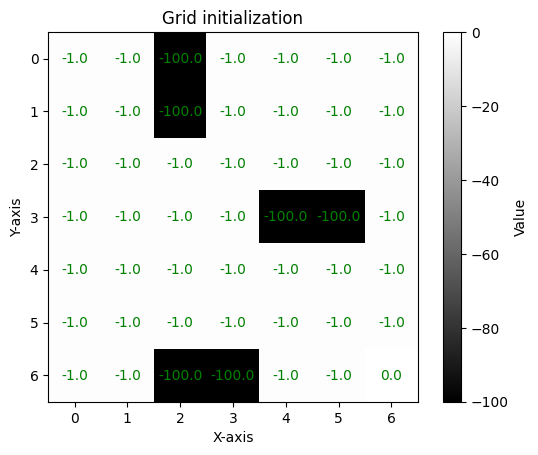

In [9]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTION_SYMBOLS = {ACTION_UP: '↑', ACTION_DOWN: '↓', ACTION_LEFT: '←', ACTION_RIGHT: '→'}

border = f"\n{'='*60}\n"
obstacles = [(0, 2), (1, 2), (3, 4), (3, 5), (6, 2), (6, 3)]
grid, start, end = generate_grid_world(obstacles)
print(border)
visualize_map(grid, "Grid initialization")
print(border)

# - policy evaluation execution (MY CODE)

In [10]:
policy = policy_generator(grid, israndom=True)
visualize_policy(policy, start, end, "Random Policy initialization", True)
# print all processes of policy evaluation
for i, v in enumerate(policy_evaluation(grid, policy, israndom=True)):
    visualize_map(v, "Value map of {}th evaluation".format(i))

Output hidden; open in https://colab.research.google.com to view.

# Show policy iteration results
### - Given

In [11]:
# Policy initialization
random_policy = policy_generator(grid, israndom=True)
visualize_policy(random_policy, start, end, "Random Policy initialization", True)

# Policy iteration
optimal_policy = 0
optimal_value = 0
# print all processes of policy iteration
for i, (optimal_policy, optimal_value) in enumerate(policy_iteration(grid, 200)):
    visualize_map(optimal_value, "{}th evaluated Value".format(i))
    visualize_policy(optimal_policy, start, end, "{}th improved Policy".format(i), True)
visualize_map(optimal_value, "Value map of optimal policy")
visualize_policy(optimal_policy, start, end, "Improved Policy after Policy Improvement", True)

Output hidden; open in https://colab.research.google.com to view.

# Show value iteration results
### - Given

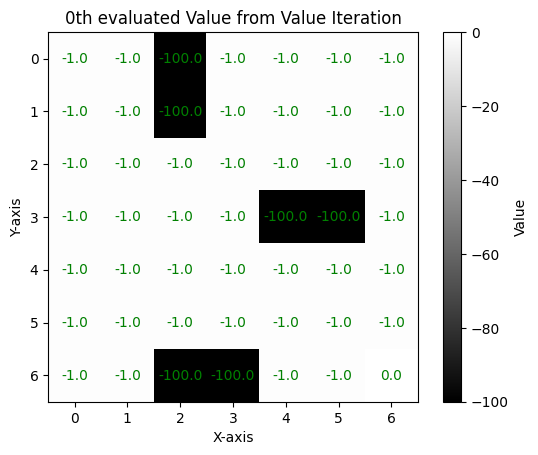

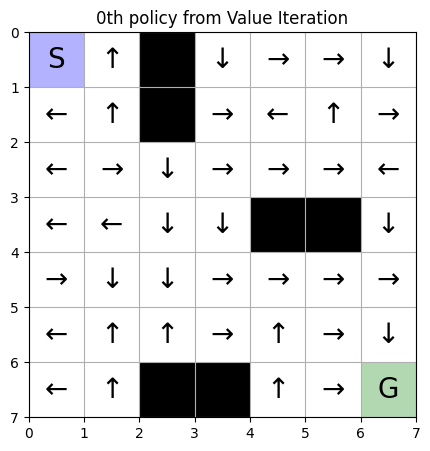

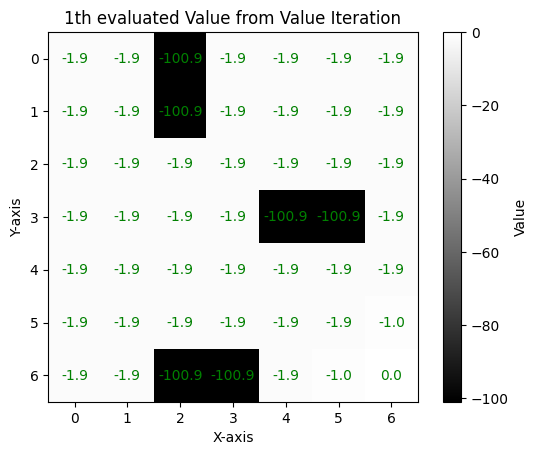

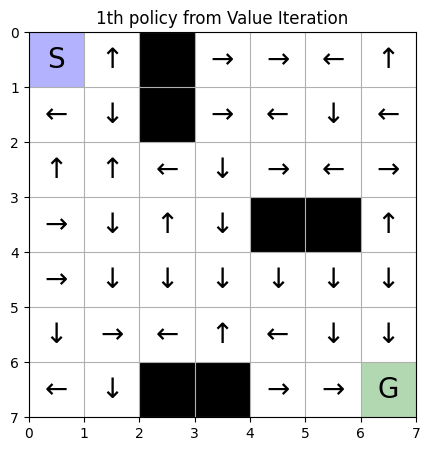

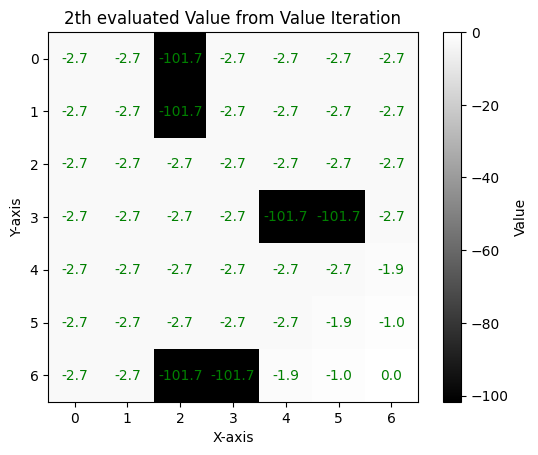

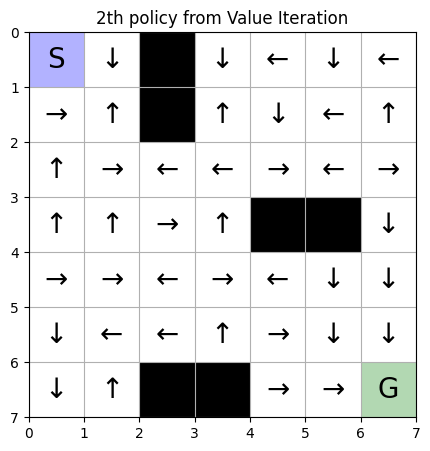

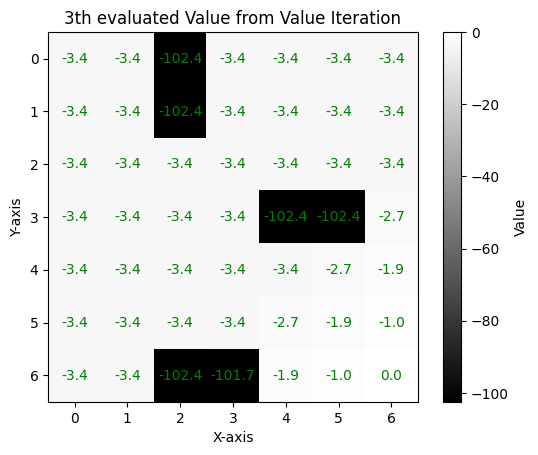

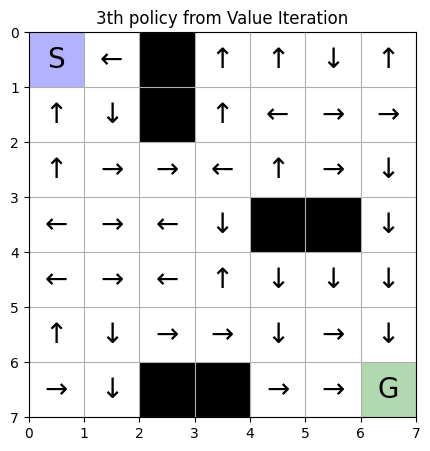

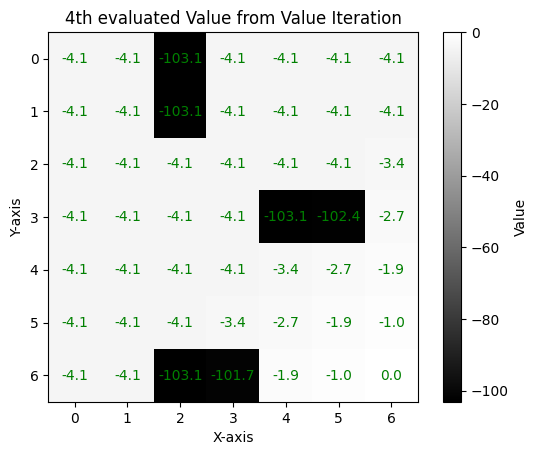

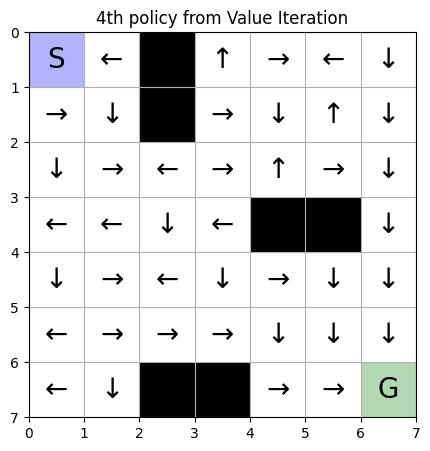

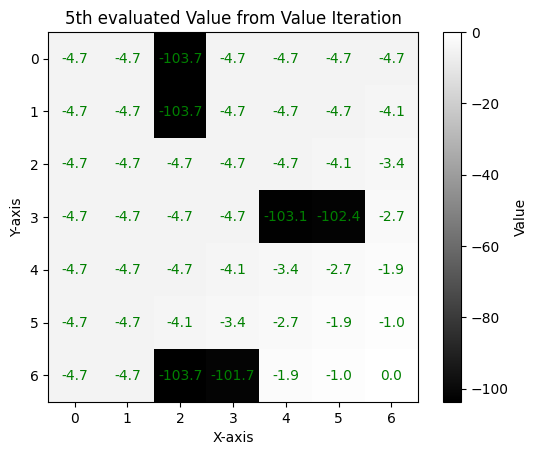

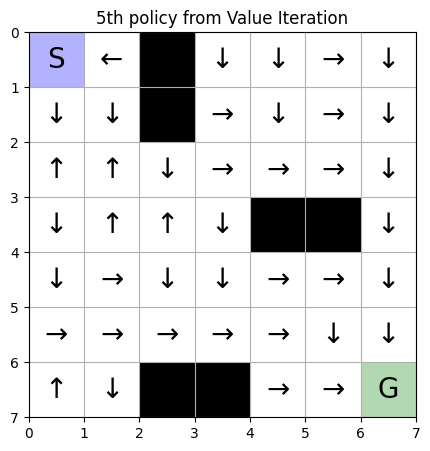

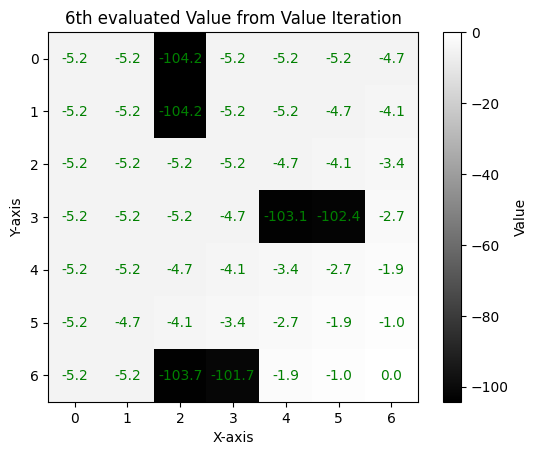

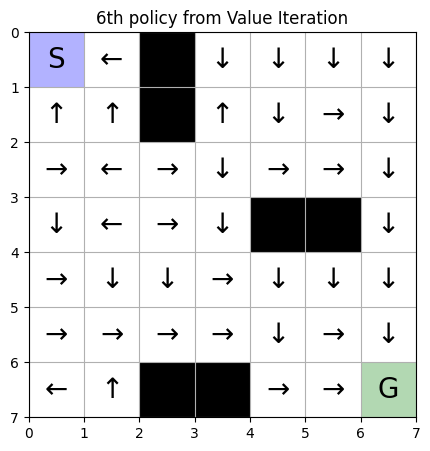

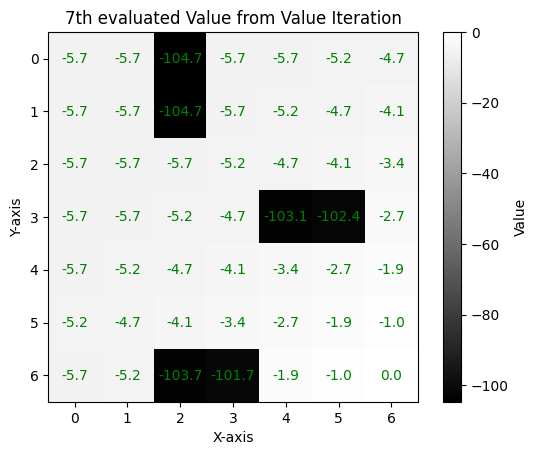

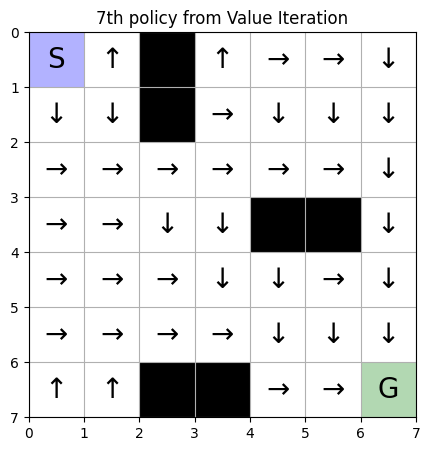

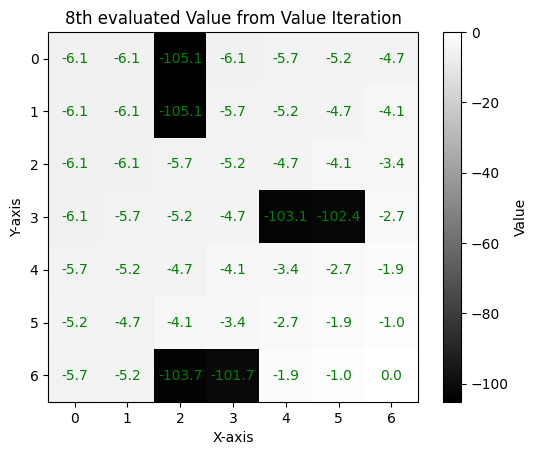

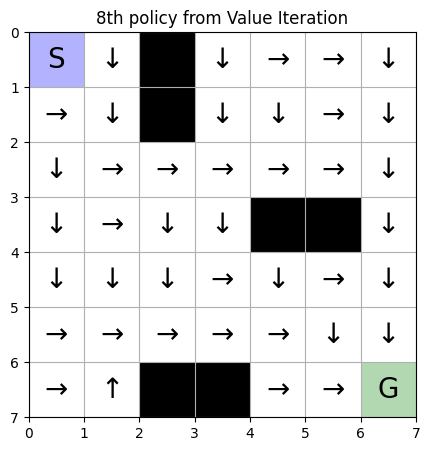

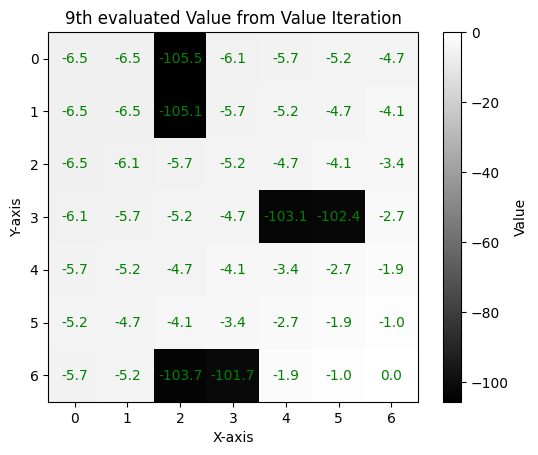

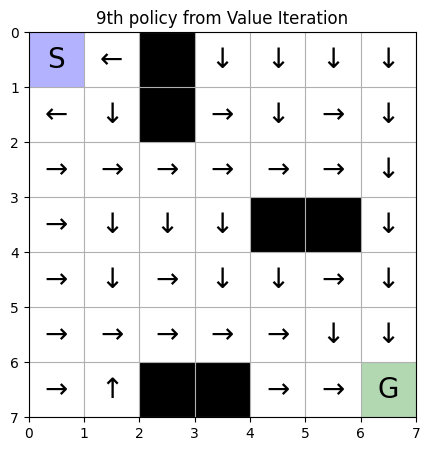

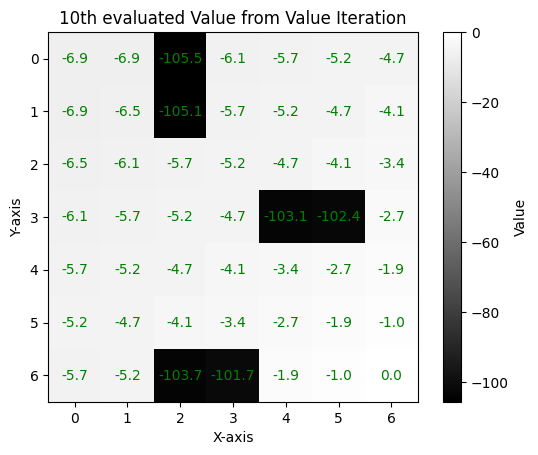

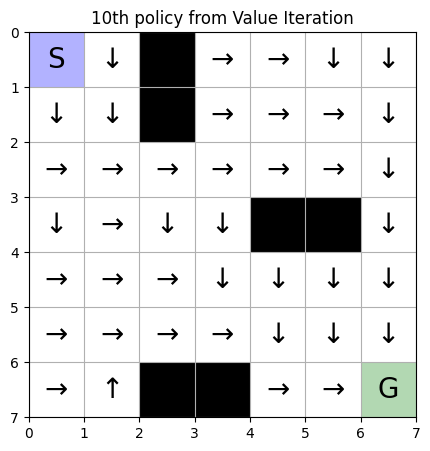

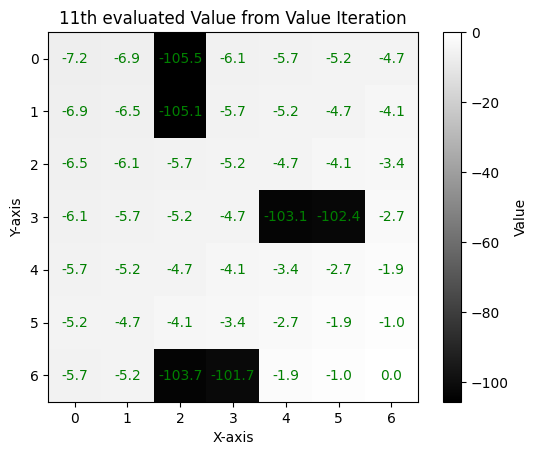

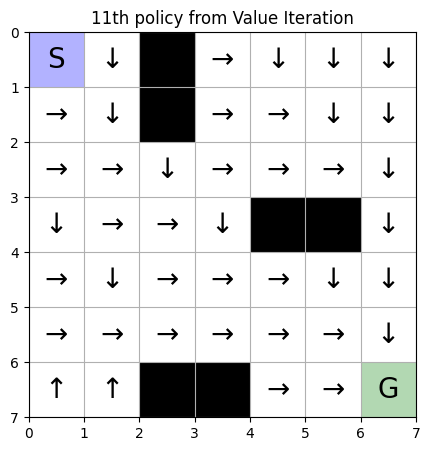

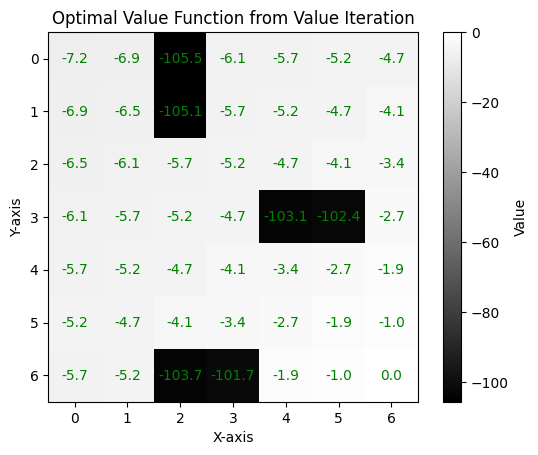

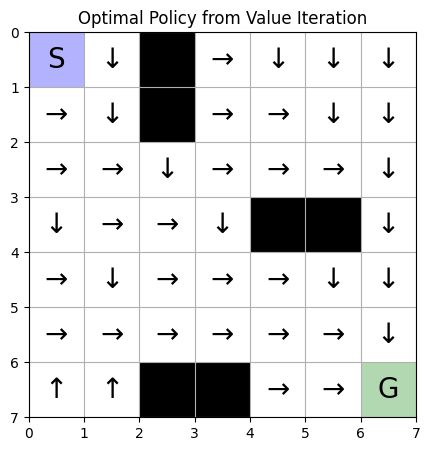

In [12]:
V_opt = 0
optimal_policy = 0
# print all processes of value iteration
for i, (V_opt, optimal_policy) in enumerate(value_iteration(grid)):
    visualize_map(V_opt, "{}th evaluated Value from Value Iteration".format(i))
    visualize_policy(optimal_policy, start, end, "{}th policy from Value Iteration".format(i), True)


visualize_map(V_opt, "Optimal Value Function from Value Iteration")
visualize_policy(optimal_policy, start, end, "Optimal Policy from Value Iteration", True)